# Enfield, Andrew - DATA 512, A1: Data curation

This notebook pulls, prepares, and analyzes data about the amount of monthly English Wikipedia traffic from January 1, 2008 through September 30, 2017. For more information about the work and data, refer to the [README](Readme.md).

A few notes:
- Normally I'd prefer to keep the explanation and background that's in the README here in the notebook, so everything's in a single file, but I've split it up this time as that's what the assignment requested. I won't copy/paste because keeping duplicate content in sync is horrible.
- Real reproducibility needs tests for the code. A lot of my implementation below is in functions. I'd normally put these functions in at least one separate file that I import into this notebook, and I'd have tests in an additional file. For this assignment I'll just keep everything in this file, for simplicity, even though it means I can't test the code the way I normally would.

# Prereqs 

This code requires the libraries as described below.

In [1]:
# load data
import requests
import os
import json

# prepare and analyze data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText # for addtl annotations in charts
from matplotlib.ticker import FuncFormatter # for custom axis labels
from IPython.core.pylabtools import figsize
import seaborn as sns # for formatting
%matplotlib inline 

In [2]:
sns.set_style("whitegrid")
figsize(14,7)

# Load data

This section loads the data from the two APIs described in the [README](README.md), producing five separate .json files, one for each API and access combination.

First, I'll define some variables to hold the date ranges we'll use. Passing the the exact ending day of the last month, as I do here, causes the API to return the same same result as passing a day in the following month; passing the ending day also simplifies the filename generation code below because that code doesn't need to 'go back in time' to output the correct month value.

In [3]:
PAGECOUNTS_START = '2008010100'
PAGECOUNTS_END = '2016073100'
PAGEVIEWS_START = '2015070100'
PAGEVIEWS_END = '2017093000'

API_DATE_FORMAT = '%Y%m%d%H'

USER_AGENT = 'https://github.com/aenfield'

Then I'll define functions that hold the logic I'll use to name and load each file.

In [4]:
def get_param_dict_from_params(access, start, end):
    """Convenience function to get a params dict for the API call given the passed values."""
    return {'access': access, 'start': start, 'end': end}

In [5]:
def get_filename_from_params(apiname, params):
    """Return a filename, for saving or loading JSON, given the API and required parameters."""
    
    # Mark up the dict so we can pass a dict with all values we need.
    # We have to format the start/end because .format doesn't handle
    # string slicing in the format string itself. We'll use a copy
    # so we don't modify the passed dict as an undesirable side effect.
    p = params.copy()
    p['apiname'] = apiname 
    p['start'] = p['start'][:6] # we only want year/month - could convert to datetime and format but this is simpler given that we know the input format
    p['end'] = p['end'][:6]
    return "{apiname}_{access}_{start}_{end}.json".format(**p)

In [6]:
def download_page_access_data(apiname, params, user_agent, force=False, verbose=False):
    """Download and save results from the specified API to a local file, by default only if local file doesn't exist.
    
    apiname - 'pagecounts' or 'pageviews'
    params - a dict containing 'access', 'start', and 'end' keys; use get_param_dict_from_params
    user_agent - an identifier for the user making the request; can be a GitHub user URL or general email address
    force - download data and overwrite local file, even if file already exists; default is False
    verbose - print diagnostic data; default is false
    """
    
    filename = get_filename_from_params(apiname, params)
    if verbose: print("Using filename: {}.".format(filename)) 
    
    if (not os.path.exists(filename)) | (force == True):
        if (apiname == 'pagecounts'):
            endpoint_template = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/{access}/monthly/{start}/{end}'
        elif (apiname == 'pageviews'):
            endpoint_template = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/{access}/user/monthly/{start}/{end}'
        # note that I'm not checking for valid apiname values - per what I understand
        # standard Python practice to be, it's the caller's responsibility to pass
        # correct values - here if they don't, the REST request will fail

        url = endpoint_template.format(**params)
        if verbose: print("Retrieving {} .".format(url))
            
        response = requests.get(url, headers = {'User-Agent':'{}'.format(user_agent)})
        if verbose: print("Done with retrieval. Status code: {}.".format(response.status_code))
            
        with open(filename, 'w') as file:
            file.write(response.text) # requests doesn't have a method to download and write at the same time, like urllib, so we write here (urllib doesn't easily enable user agent setting, so we don't use it)
        if verbose: print("Saved file.")
    else:
        if verbose: print("Local file exists already.")

And specify the required parameters for each API call.

In [7]:
data_specs = [('pagecounts', 'desktop-site', PAGECOUNTS_START, PAGECOUNTS_END),
              ('pagecounts', 'mobile-site', PAGECOUNTS_START, PAGECOUNTS_END),
              ('pageviews', 'desktop', PAGEVIEWS_START, PAGEVIEWS_END),
              ('pageviews', 'mobile-web', PAGEVIEWS_START, PAGEVIEWS_END),
              ('pageviews', 'mobile-app', PAGEVIEWS_START, PAGEVIEWS_END)]

And finally, I'll download the data and save to a file, for each API and access combination, producing five files. I've set the 'force' argument to True to show the data being downloaded; setting it to false would make the code only download the data if a local file doesn't already exist.

In [8]:
for (apiname, access, start, end) in data_specs:
    download_page_access_data(apiname, get_param_dict_from_params(access, start, end), 
                         USER_AGENT, force=True, verbose=True)

Using filename: pagecounts_desktop-site_200801_201607.json.
Retrieving https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2016073100 .
Done with retrieval. Status code: 200.
Saved file.
Using filename: pagecounts_mobile-site_200801_201607.json.
Retrieving https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2008010100/2016073100 .
Done with retrieval. Status code: 200.
Saved file.
Using filename: pageviews_desktop_201507_201709.json.
Retrieving https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017093000 .
Done with retrieval. Status code: 200.
Saved file.
Using filename: pageviews_mobile-web_201507_201709.json.
Retrieving https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2015070100/2017093000 .
Done with retrieval. Status code: 200.
Saved file.
Using fi

# Prepare data

Then, I'll prepare the data, ultimately producing a single dataframe with a row per month and columns for the counts from each API access value and columns for the sum totals from the two APIs.

First, I define a function here that prepares the data from a single API call/.json file, and then call this function for each of the five files. The function loads the data from the file, creates a dataframe from JSON, adds/renames/drops columns to make the data consistent across dataframes/files, and creates a date-based row index.

In [9]:
def get_cleaned_dataframe(apiname, access, start, end):
    """Load the data from the file with specified apiname, access, start, and dates and return a cleaned 
    dataframe suitable for further use with data from other API calls."""

    filename = get_filename_from_params(apiname, get_param_dict_from_params(access, start, end))
    with open(filename) as json_data:
        d_as_json = json.load(json_data)

    # pandas read_json needs the data as a string (not parsed JSON) and without the 
    # 'items' preface that the API returns; we can't let read_json convert dates because it 
    # doesn't handle this format ok - we'll convert next
    df = pd.read_json(json.dumps(d_as_json['items']), orient='records', convert_dates=False)
    
    # add column that specifies the api from which this dataframe came
    df['api'] = apiname
    
    # make the columns consistent across different API calls
    # rename doesn't error if the column doesn't exist, so no need to special case dataframes from diff APIs
    df.rename(columns = {'access-site': 'access', 'count': 'views'}, inplace=True)
    
    # get rid of columns we don't need
    # use ignore so we don't fail on dfs that don't have all columns
    df.drop(['agent', 'project', 'granularity'], axis=1, errors='ignore', inplace=True) 
    
    # create and use a date-based row index
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=API_DATE_FORMAT)
    df.set_index('timestamp', inplace=True)

    return df

Then, use the above function to get a cleaned dataframe for each API call/file, and store these dataframes in a dict indexed by the API and access value.

In [10]:
all_data_as_dfs = {f'{apiname}_{access}' : get_cleaned_dataframe(apiname, access, start, end) for 
                   (apiname, access, start, end) in data_specs}
len(all_data_as_dfs)

5

Then sum the 'mobile-web' and 'mobile-app' totals from the Pageviews API to create a new dataframe in the same format as the dataframes from the data files.

In [11]:
pageviews_mobile_df = (all_data_as_dfs['pageviews_mobile-web']['views'] + all_data_as_dfs['pageviews_mobile-app']['views']).to_frame()
pageviews_mobile_df['access'] = 'mobile'
pageviews_mobile_df['api'] = 'pageviews'
pageviews_mobile_df[:3]

,views,access,api
timestamp,,,
2015-07-01,3288755294,mobile,pageviews
2015-08-01,3302333038,mobile,pageviews
2015-09-01,3170203333,mobile,pageviews


Then combine the dataframes that hold the data I'm going to visualize. This is four dataframes: two dataframes directly from the Pagecounts API, one dataframe for desktop data directly from the Pageviews API, and one dataframe created immediately previous with mobile data from the Pageviews API.

The resulting dataframe is in 'long' format: it has a row per combination of month, API, and access.

In [12]:
all_data_long = pd.concat([all_data_as_dfs['pagecounts_desktop-site'], all_data_as_dfs['pagecounts_mobile-site'],
                           all_data_as_dfs['pageviews_desktop'], pageviews_mobile_df])
len(all_data_long)

179

Just to be careful, I'll sanity check the number of rows from different APIs and access values.

In [13]:
all_data_long['api'].value_counts(dropna=False)

pagecounts    125
pageviews      54
Name: api, dtype: int64

In [14]:
all_data_long['access'].value_counts(dropna=False)

desktop-site    103
mobile           27
desktop          27
mobile-site      22
Name: access, dtype: int64

In [15]:
all_data_long[:2]

,access,api,views
timestamp,,,
2008-01-01,desktop-site,pagecounts,4930902570
2008-02-01,desktop-site,pagecounts,4818393763


Ultimately I want to visualize by month and output a .csv with a row per month and columns for each API/access combination. Here I pivot the above 'long' dataframe into a 'wide' dataframe with a row per month and a column per API/access combination.

In [16]:
all_data_wide = all_data_long.pivot(columns='access', values='views')
all_data_wide[:3]

access,desktop,desktop-site,mobile,mobile-site
timestamp,,,,
2008-01-01,NaN,4.930903e+09,NaN,NaN
2008-02-01,NaN,4.818394e+09,NaN,NaN
2008-03-01,NaN,4.955406e+09,NaN,NaN


Then I rename the columns to the names specified in the assignment.

In [17]:
all_data_wide.rename(columns = {'desktop':'pageview_desktop_views',
                                'mobile':'pageview_mobile_views',
                                'desktop-site':'pagecount_desktop_views',
                                'mobile-site':'pagecount_mobile_views'}, inplace=True)

all_data_wide.columns.name = '' # don't want the default column index name of 'access' anymore

all_data_wide[:3]

,pageview_desktop_views,pagecount_desktop_views,pageview_mobile_views,pagecount_mobile_views
timestamp,,,,
2008-01-01,NaN,4.930903e+09,NaN,NaN
2008-02-01,NaN,4.818394e+09,NaN,NaN
2008-03-01,NaN,4.955406e+09,NaN,NaN


And I add columns to hold the totals for each month from the Pagecounts and Pageviews APIs, using fillna to replace NaN values with zero so the addition returns a number and not NaN.

In [18]:
all_data_wide['pagecount_all_views'] = all_data_wide['pagecount_desktop_views'].fillna(0) + all_data_wide['pagecount_mobile_views'].fillna(0)
all_data_wide['pageview_all_views'] = all_data_wide['pageview_desktop_views'].fillna(0) + all_data_wide['pageview_mobile_views'].fillna(0)
all_data_wide[:3]

,pageview_desktop_views,pagecount_desktop_views,pageview_mobile_views,pagecount_mobile_views,pagecount_all_views,pageview_all_views
timestamp,,,,,,
2008-01-01,NaN,4.930903e+09,NaN,NaN,4.930903e+09,0.0
2008-02-01,NaN,4.818394e+09,NaN,NaN,4.818394e+09,0.0
2008-03-01,NaN,4.955406e+09,NaN,NaN,4.955406e+09,0.0


Then sort the columns so data from each API is next to each other.

In [19]:
all_data_wide = all_data_wide.reindex_axis(sorted(all_data_wide.columns), axis=1)

For a cleaner chart, we want every column and row combination for which we know we have no valid data to hold NaN. By default a line chart doesn't plot anything when for NaN values, which is what we want because in this case 'nothing' tells us we have no data, instead of falsely telling us that we could have page views but just didn't. 

The columns directly from the API calls already hold NaNs, so we only need to set NaNs for the two sum total columns. I don't set NaN for every row - I only set it for rows for which I retrieved data, using the date range variables defined previously.

In [20]:
all_data_wide.loc[all_data_wide.index > pd.to_datetime(PAGECOUNTS_END, format='%Y%m%d%H'), 'pagecount_all_views'] = np.nan
all_data_wide.loc[all_data_wide.index < pd.to_datetime(PAGEVIEWS_START, format='%Y%m%d%H'), 'pageview_all_views'] = np.nan

In [21]:
all_data_wide[:2]

,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
timestamp,,,,,,
2008-01-01,4.930903e+09,4.930903e+09,NaN,NaN,NaN,NaN
2008-02-01,4.818394e+09,4.818394e+09,NaN,NaN,NaN,NaN


# Visualize for analysis

Finally, draw the chart.

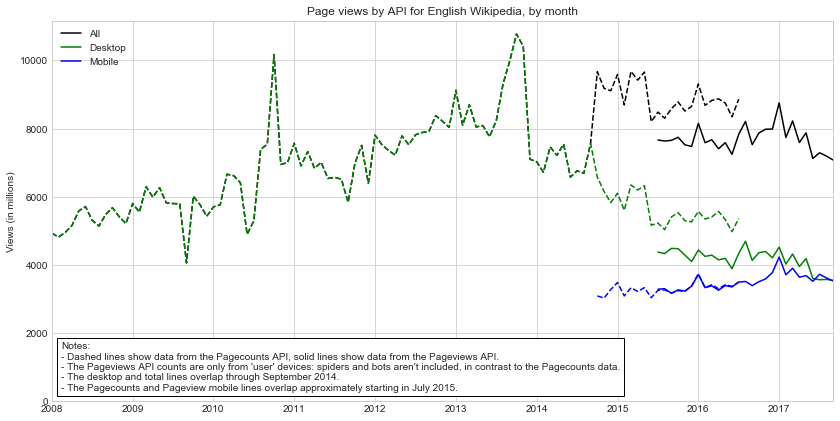

In [22]:
ax = all_data_wide.plot(title='Page views by API for English Wikipedia, by month', 
                        ylim=0, sort_columns=True, style=['k--','g--','b--', 'k', 'g', 'b']) 
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: f'{x / 1000000.0:.0f}'))
plt.ylabel('Views (in millions)')
plt.xlabel('') # don't need name of index, which is 'timestamp'

# overwrite default pandas legend, which shows six labels, with a legend 
# that only shows one row per type (all, desktop, mobile)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[3:], ['All','Desktop','Mobile'], loc=2)

note_text = """Notes:
- Dashed lines show data from the Pagecounts API, solid lines show data from the Pageviews API.
- The Pageviews API counts are only from 'user' devices: spiders and bots aren't included, in contrast to the Pagecounts data.
- The desktop and total lines overlap through September 2014.
- The Pagecounts and Pageview mobile lines overlap approximately starting in July 2015."""
ax.add_artist(AnchoredText(note_text, loc=3, prop=dict(size=10)))

plt.savefig('page_views_by_api.png', dpi=300)

And then output the final processed data as a .csv file.

The assignment requires separate columns for the year and month, so I'll create those columns here from the row index, and then when I output the .csv leave out the single datetime column entirely.

In [23]:
# this code specifies the index for each Series so that values are appropriately associated with the 
# index values that already exist in the data frame - without this, the Series that is
# returned from the right side has the default integer index values, and since these
# don't match the index values in the dataframe, the assignment would just result in 
# all np.nan values for the new year and month columns
all_data_wide['year'] = pd.Series(all_data_wide.index.map(lambda dt: pd.Timestamp(dt).year), index=all_data_wide.index)
all_data_wide['month'] = pd.Series(all_data_wide.index.map(lambda dt: f"{pd.Timestamp(dt).month:02}"), index=all_data_wide.index) # format to pad with leading zero

In [24]:
# dates are the first date of the old API to the last date of the new API
filename_output = f'en-wikipedia_traffic_{PAGECOUNTS_START[:6]}-{PAGEVIEWS_END[:6]}.csv'
filename_output

'en-wikipedia_traffic_200801-201709.csv'

In [25]:
all_data_wide.fillna(0).to_csv(filename_output, index=False)